This is Tensorflow 2 implementation of GoogleNet model based on the paper in the below link
https://static.googleusercontent.com/media/research.google.com/en//pubs/archive/43022.pdf

Few of the major differences between the paper and this implementation are


1.   Number of categories for classification here is 10 compared to the paper's 1000
2.   In the paper, conv layers use relu activation layer, but in this implementation elu is used instead



In [1]:
#For any array manipulations
import numpy as np

#For plotting graphs
import matplotlib.pyplot as plt
# For loading data from the file system
import os

# For randomly selecting data from the dataset
import random

# For displaying the confusion matrix in a pretty way
import pandas

# loading tensorflow packages
import tensorflow as tf
from tensorflow.keras import Model, Input
from tensorflow.keras.layers import Conv2D, MaxPool2D, AveragePooling2D, Concatenate, Dense, BatchNormalization, Dropout, Flatten
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.initializers import RandomNormal

print(tf.__version__)



2.5.0


# Initializations

In [2]:
from tensorflow.python.client import device_lib

def get_available_gpus():
    local_device_protos = device_lib.list_local_devices()
    return [x.name for x in local_device_protos if x.device_type == 'GPU']
print("devices =" , tf.config.list_physical_devices())

print(get_available_gpus()) 

devices = [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
['/device:GPU:0']


In [3]:
# Shape of the input images height=width=224 channels = 3
input_shape=(224,224,3) 

# batch_size is the number of images in a batch to train and test the model
batch_size = 100 

# num_classes is the number of cateegories that input images havee to be classified into
# This has to be set based on the input dataset
# For the dataset the paper uses, num_classes = 1000
num_classes = 5


# Based on computational power availability, size_factor can be varied. 
# This will determine the model complexity and number of trainable parameters
# This affects the feature map size of all conv layers
# The model from the paper uses size_factor=64
size_factor = 32

checkpoint_filePath = '/content/drive/MyDrive/MachineLearning/GoogleNet_experiment_1.h5'

In [4]:
#initializing the random seed so that we get consistent results
def set_seed(seed=31415):
    np.random.seed(seed)
    tf.random.set_seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    os.environ['TF_DETERMINISTIC_OPS'] = '1'
set_seed()

# Data Loading and Preprocessing

## Procuring the dataset


In [5]:
path='/content/Linnaeus 5 256X256'
# Check if the folder with the dataset already exists, if not copy it from the saved location
if not os.path.isdir(path):
  !cp '/content/drive/MyDrive/MachineLearning/Linnaeus 5 256X256.rar' '/content/' 
  get_ipython().system_raw("unrar x '/content/Linnaeus 5 256X256.rar'")



categories = os.listdir(os.path.join(path, 'train'))
print(len(categories), " categories found =", categories)

5  categories found = ['dog', 'berry', 'other', 'bird', 'flower']


## Training and Validation Datasets

In [6]:

train_image_dataset = tf.keras.preprocessing.image_dataset_from_directory(
        os.path.join(path, 'train')
      , labels='inferred'
      , label_mode='categorical'
      , class_names=categories
      , batch_size=batch_size
      , image_size=(256, 256)
      , shuffle=True
      , seed=2
      , validation_split=0.1
      , subset= 'training'
  )

validation_image_dataset = tf.keras.preprocessing.image_dataset_from_directory(
        os.path.join(path, 'train')
      , labels='inferred'
      , label_mode='categorical'
      , class_names=categories
      , batch_size=batch_size
      , image_size=(256, 256)
      , shuffle=True
      , seed=2
      , validation_split=0.1
      , subset= 'validation'
  )


print("Training class names found =" , train_image_dataset.class_names)

def crop_images(images, labels):
  '''
  Expecting categories to be names of subfolders and the images belonging to each 
  of the subfolders be stored inside them. While reading the images, they are resized to 256x256x3
  and then cropped to 224x224x3 based on the way the paper describes (randomly between 4 corners and center)
  diagnostics: bool (default False), If True it will print a lot of debug information

  '''
  # In order to clip the image in either from top-left, top-right, bottom-left, bottom-right or center, 
  # we create an array of possible start positions
  corners_list = [0, (256-input_shape[0])//2, 256-input_shape[0]]
  
  # Sampling one number from the list of start positions
  offset_height = offset_width = random.sample(corners_list, 1)[0]
  
  images = tf.image.per_image_standardization(images-127)
  images = images/tf.math.reduce_max(tf.math.abs(images))

  # Since there is an auxillary arm of the model, we have to concatenate two labels with each other during training
  return  tf.image.crop_to_bounding_box(images, offset_height, offset_width, input_shape[0], input_shape[0]), labels #(labels, labels)


validation_datasource = validation_image_dataset.map(crop_images)
validation_datasource = validation_datasource.cache().prefetch(buffer_size=tf.data.AUTOTUNE).shuffle(batch_size)

training_datasource = train_image_dataset.map(crop_images)
training_datasource = training_datasource.cache().prefetch(buffer_size=tf.data.AUTOTUNE).shuffle(batch_size)



Found 6000 files belonging to 5 classes.
Using 5400 files for training.
Found 6000 files belonging to 5 classes.
Using 600 files for validation.
Training class names found = ['dog', 'berry', 'other', 'bird', 'flower']


In [7]:
for images, labels in training_datasource:
  print("images =", images.shape)
  print("labels =", type(labels))
  break

training_datasource = train_image_dataset.map(crop_images)
training_datasource = training_datasource.cache().prefetch(buffer_size=tf.data.AUTOTUNE).shuffle(batch_size)


images = (100, 224, 224, 3)
labels = <class 'tensorflow.python.framework.ops.EagerTensor'>


## Test Data

In [8]:
test_image_dataset = tf.keras.preprocessing.image_dataset_from_directory(
        os.path.join(path, 'test')
      , labels='inferred'
      , label_mode='categorical'
      , class_names=categories
      , batch_size=batch_size
      , image_size=(256, 256)
      , seed=2
  )
def test_data_crop_images(images, labels):
  '''
  Definiing separate function for test data because labels do not have to be 
   concatenated during testing and the map function does not allow multiple function calls

  Expecting categories to be names of subfolders and the images belonging to each 
  of the subfolders be stored inside them. While reading the images, they are resized to 256x256x3
  and then cropped to 224x224x3 based on the way the paper describes (randomly between 4 corners and center)
  diagnostics: bool (default False), If True it will print a lot of debug information

  '''
  # In order to clip the image in either from top-left, top-right, bottom-left, bottom-right or center, 
  # we create an array of possible start positions
  corners_list = [0, (256-input_shape[0])//2, 256-input_shape[0]]
  
  # Sampling one number from the list of start positions
  offset_height = offset_width = random.sample(corners_list, 1)[0]
  
  images = tf.image.per_image_standardization(images-127)
  images = images/tf.math.reduce_max(tf.math.abs(images))
  # Since there is an auxillary arm of the model, we have to concatenate two labels with each other during training
  return  tf.image.crop_to_bounding_box(images, offset_height, offset_width, input_shape[0], input_shape[0]), labels


test_datasource = test_image_dataset.map(test_data_crop_images)
test_datasource = test_datasource.cache().prefetch(buffer_size=tf.data.AUTOTUNE).shuffle(batch_size)

Found 2000 files belonging to 5 classes.


# Building the GoogleNet Architecture

## Define the inception block

In [9]:
def inception_block(input, intermediate_filter_size,  output_filter_size
                    , kernel_initializer, bias_initializer
                    , use_bias=True, name_prefix=''):
  '''
  input = input tensor that has to be opeerated on
  intermediate_filter_size = dictionary that keys 3 and 5
    {3: filter size of Conv1x1 in the Conv3x3 pipeline,
     5: filter size of Conv1x1 in the Conv5x5 pipeline
    }  
  output_filter_size = dictionary that have keys 1, 3 and 5
    {1: filter size of the Conv1x1 filter in the Conv1x1 pipeline,
     3: filter size of the Conv3x3 filter in the Conv3x3 pipeline,
     5: filter size of the Conv5x5 filter in the Conv5x5 pipeline
    }
  name_prefix = string that will be prefixed with each of the layers' names in the block
  '''
  initializer = RandomNormal(mean=0.5, stddev=0.1, seed = 7)

  # Conv 1x1 pipeline taking the input and feeding directly to the output
  conv1 = Conv2D(filters = output_filter_size[1], kernel_size=1, strides = 1
                 , activation='elu', padding='same', use_bias=use_bias
                 , kernel_initializer = kernel_initializer, bias_initializer=bias_initializer
                 , name=name_prefix + 'conv1' ) (input)

  # Defining Conv 1x1 -> Conv 3x3 pipeline
  conv1_3 = Conv2D(filters= intermediate_filter_size[3], kernel_size = 1, strides = 1
                   , activation='elu', padding='same', use_bias=use_bias
                   , kernel_initializer = kernel_initializer, bias_initializer=bias_initializer
                   , name=name_prefix + 'conv1_3')(input)
  conv3 = Conv2D(filters = output_filter_size[3], kernel_size = 3, strides = 1
                 , activation='elu', padding='same', use_bias=use_bias
                 , kernel_initializer = kernel_initializer, bias_initializer=bias_initializer
                 , name=name_prefix + 'conv3' )(conv1_3)

  # Defining the Conv1x1 -> Conv5x5 pipeline
  conv1_5 = Conv2D(filters= intermediate_filter_size[5], kernel_size = 1, strides = 1
                   , activation='elu', padding='same', use_bias=use_bias
                   , kernel_initializer = kernel_initializer, bias_initializer=bias_initializer
                   , name=name_prefix + 'conv1_5')(input)
  conv5 = Conv2D(filters = output_filter_size[5], kernel_size = 5, strides = 1
                 , activation='elu', padding='same', use_bias=use_bias
                 , kernel_initializer = kernel_initializer, bias_initializer=bias_initializer
                 , name=name_prefix + 'conv5' )(conv1_5)

  # Defining the MaxPool pipeline
  max_pool = MaxPool2D(pool_size=3, strides=1, padding='same'
                  , name=name_prefix + 'maxpool')(input)
  conv_projection = Conv2D(filters = output_filter_size['proj'], kernel_size=1, strides=1
                           , activation='elu', padding='same', use_bias=use_bias
                           , kernel_initializer = kernel_initializer, bias_initializer=bias_initializer
                           , name=name_prefix + 'proj')(max_pool)

  # Concatenating the output of the above pipelines
  output = Concatenate(axis=3
                       , name=name_prefix + 'concat')([conv1, conv3, conv5, conv_projection])

  return output


## Defining the Auxillary Branch block

In [10]:
def auxillary_branch(input, num_classes, kernel_initializer , bias_initializer
                     , filter_size = 128
                     
                     , use_bias=True, name_prefix=''):
  #initializer = RandomNormal(mean=0.5, stddev=0.1, seed = 7)
  avg_pool = AveragePooling2D(pool_size=5, strides=3, padding='valid'
              , name=name_prefix + 'avg_pool')(input)
  conv = Conv2D(filters= filter_size , kernel_size=1, strides=1
                , padding='same', activation='elu', use_bias=use_bias
                , kernel_initializer = kernel_initializer, bias_initializer=bias_initializer
                , name=name_prefix + 'conv')(avg_pool)
  dense = Dense(units = 1024, activation='elu'
                , kernel_initializer = kernel_initializer, bias_initializer=bias_initializer
                , name=name_prefix + 'fc')(conv)
  dropout = Dropout(0.7, name=name_prefix + 'dropout')(dense)
  flatten = Flatten(name=name_prefix+'flatten')(dropout)
  output = Dense(units = num_classes, activation='softmax'
                , kernel_initializer = kernel_initializer, bias_initializer=bias_initializer
                , name=name_prefix + 'output')(flatten)

  return output

## Define the actual model

In [11]:
def build_googleNet(input_shape, size_factor=64, activation='elu'
                    , use_bias=True, num_classes=10):
  '''
  input_shape = tuple of 3 numbers (height, width, channels)
  batch_size = number of images per batch

  size_factor = int (default 64). As per the paper, this should be 64. 
    Since all the convolutions are sized as multiples of 64, this is made configurable to be able to train a lighter version of the network if needed
  activation = str (default 'elu') Since this is a big network, I have chosen to go with elu activation to give the layers a way our of ending up with dead relus
  '''
  
  kernel_initializer = tf.keras.initializers.GlorotUniform()#(mean=0.5, stddev=0.1, seed = 7)
  bias_initializer = tf.keras.initializers.GlorotUniform() #(0.2)
  input = Input(shape = input_shape, batch_size = batch_size , name="main_input")

  # First portion of GoogleNet Architecture is similar to AlexNet/ LeNet 
  # i.e. a single pipeline
  # Definining this here

  #Conv layer for output 112x112x64
  conv_layer_1 = Conv2D(filters=size_factor, kernel_size = 7, strides = 2, activation='elu'
                  , padding= 'same', use_bias=use_bias
                  , kernel_initializer = kernel_initializer, bias_initializer=bias_initializer
                  , name='conv_layer_1')(input)
  # MaxPool will give out 56x56x64                
  maxpool_1=MaxPool2D(pool_size = 3, strides = 2, padding='same'
                  , name='maxpool_1')(conv_layer_1)

  # Adding Norm layer as per the textbook
  norm_1 = BatchNormalization(name='norm_1')(maxpool_1)


  # Paper says the next Conv3x3 layer needs a reduction layer as well
  # Defining the reduction layer of Conv with output 56x56x64
  conv_layer_2a = Conv2D(filters = size_factor, kernel_size = 1, strides = 1, activation ='elu'
                , padding='same', use_bias=use_bias
                , kernel_initializer = kernel_initializer, bias_initializer=bias_initializer
                , name='conv_layer_2') (norm_1)

  # Now defining the actual conv3x3 layer output of 28x28x192
  conv_layer_2b = Conv2D(filters = size_factor*3, kernel_size = 3, strides = 1, activation='elu'
                , padding='same', use_bias=use_bias
                , kernel_initializer = kernel_initializer, bias_initializer=bias_initializer
                , name='conv_layer_3')(conv_layer_2a)
  # max_pool should output 28x28x192              
  max_pool_2 = MaxPool2D(pool_size=3, strides = 2, padding='same'
                , name='maxpool_2')(conv_layer_2b)

  # Creeating the first inception block 3a with output 28x28x256 
  inception3a = inception_block(max_pool_2, intermediate_filter_size={3:96, 5:16}
                ,  output_filter_size={1:size_factor
                                      , 3:size_factor*2
                                      , 5:size_factor//2
                                      , 'proj':size_factor//2}
                , use_bias=use_bias
                , kernel_initializer = kernel_initializer
                , bias_initializer=bias_initializer
                , name_prefix='incep_3a_')

  # Inception Block 3b with output 28x28x480
  inception3b = inception_block(inception3a, intermediate_filter_size={3:128, 5:32}
                                ,  output_filter_size={1:size_factor*2
                                                      , 3:size_factor*3
                                                      , 5:int(size_factor*1.5)
                                                      , 'proj':size_factor}
                                , use_bias=use_bias
                                , kernel_initializer = kernel_initializer
                                , bias_initializer=bias_initializer
                                , name_prefix='incep_3b_')

  # Paper specifies a MaxPool layer here output= 14x14x480
  max_pool_3 = MaxPool2D(pool_size=3, strides = 2, padding='same', name='max_pool_3')(inception3b)

  #Inception Block 4a,  output = 14x14x512
  inception4a = inception_block(max_pool_3,   intermediate_filter_size={3:112, 5:24}
                                ,  output_filter_size={1:size_factor*3
                                                      , 3:int(size_factor*3.25) #208
                                                      , 5:int(size_factor * 0.75) #48
                                                      , 'proj':size_factor}
                                , use_bias=use_bias
                                , kernel_initializer = kernel_initializer
                                , bias_initializer=bias_initializer
                                , name_prefix='incep_4a_')

  # First Auxillary outputs with size 1x1xnum_classes
  #output_aux1 = auxillary_branch(inception4a, num_classes
  #                               , filter_size=size_factor*2
  #                               , kernel_initializer = kernel_initializer
  #                               , bias_initializer=bias_initializer
  #                               , use_bias=use_bias, name_prefix='aux1_')

  #Inception Block 4b with output shape =14x14x512
  inception4b = inception_block(inception4a,   intermediate_filter_size={3:96, 5:16}
                                ,  output_filter_size={1:int(size_factor*2.5) #160
                                                      , 3:int(size_factor*3.5) #224
                                                      , 5:size_factor
                                                      , 'proj':size_factor}
                                , use_bias=use_bias
                                , kernel_initializer = kernel_initializer
                                , bias_initializer=bias_initializer
                                , name_prefix='incep_4b_')

  #Inception Block 4c with output shape = 14x14x512
  inception4c = inception_block(inception4b,   intermediate_filter_size={3:144, 5:32}
                                ,  output_filter_size={1:size_factor*2
                                                      , 3:size_factor * 4 #256
                                                      , 5:size_factor
                                                      , 'proj':size_factor}
                                , kernel_initializer = kernel_initializer
                                , bias_initializer=bias_initializer
                                , name_prefix='incep_4c_')

  #Inception Block 4d with output shape =14x14x528
  inception4d = inception_block(inception4c,   intermediate_filter_size={3:128, 5:24}
                                ,  output_filter_size={1:int(size_factor*1.75) #112
                                                      , 3:int(size_factor*4.5) #288
                                                      , 5:size_factor
                                                      , 'proj':size_factor}
                                , use_bias=use_bias
                                , kernel_initializer = kernel_initializer
                                , bias_initializer=bias_initializer
                                , name_prefix='incep_4d_')

  # Second Auxillary outputs with output 1x1xnum_classes
  #output_aux2 = auxillary_branch(inception4d, num_classes, filter_size=size_factor*2
  #                             , kernel_initializer = kernel_initializer, bias_initializer=bias_initializer
  #                             , use_bias=use_bias, name_prefix='aux2_')
  # The paper later said that just one auxillary branch is sufficient and there is
  # very negligible benefit from the second. Hence removed it here and excluded it from the final output

  #Inception Block 4e with output 14x14x832
  inception4e = inception_block(inception4d,   intermediate_filter_size={3:160, 5:32}
                                ,  output_filter_size={1:size_factor*4 #256
                                                      , 3:size_factor*5 #320
                                                      , 5:size_factor*2 #128
                                                      , 'proj':size_factor*2 }
                                , use_bias=use_bias
                                , kernel_initializer = kernel_initializer
                                , bias_initializer=bias_initializer
                                , name_prefix='incep_4e_')

  # Paper specifies a MaxPool layer here with output 7x7x832
  max_pool_4 = MaxPool2D(pool_size=3, strides = 2, padding='same', name='max_pool_4')(inception4e)

  #Inception Block 5a with output shape 7x7x832 
  inception5a = inception_block(max_pool_4,   intermediate_filter_size={3:160, 5:32}
                                ,  output_filter_size={1:size_factor * 4 #256
                                                      , 3:size_factor * 5 #320
                                                      , 5:size_factor * 2 #128
                                                      , 'proj':size_factor*2}
                                , use_bias=use_bias
                                , kernel_initializer = kernel_initializer
                                , bias_initializer=bias_initializer
                                , name_prefix='incep_5a_')

  #Inception Block 5b with output shape 7x7x1024
  inception5b = inception_block(inception5a,   intermediate_filter_size={3:192, 5:48}
                                ,  output_filter_size={1:size_factor * 6 #384
                                                      , 3:size_factor * 6 #384
                                                      , 5:size_factor * 2 #128
                                                      , 'proj':size_factor * 2}
                                , use_bias=use_bias
                                , kernel_initializer = kernel_initializer
                                , bias_initializer=bias_initializer
                                , name_prefix='incep_5b_')

  # Avg Pool as specified by the paper, output shape = 1x1x1024
  avg_pool = AveragePooling2D(pool_size=7, strides=1, padding='valid'
                        , name='avg_pool')(inception5b)


  dropout = Dropout(rate=0.4, name='dropout')(avg_pool)

  flatten = Flatten(name='flatten')(dropout)
  # Final FC layer with output shape 1x1xnum_classes
  pipeline_output = Dense(units=num_classes, activation='softmax'
                          , kernel_initializer = kernel_initializer
                          , bias_initializer=bias_initializer
                          , name='main_output')(flatten)

  # Adding auxillary branches for training purposes based on the paper

  # Not using the aux2 branch in the output as the paper suggested
  model = Model (inputs = input, outputs = pipeline_output, name='googleNet')

  model.summary()
  return model


In [28]:
model = build_googleNet(input_shape, size_factor=64, activation='elu', num_classes=num_classes, use_bias=True)

Model: "googleNet"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
main_input (InputLayer)         [(100, 224, 224, 3)] 0                                            
__________________________________________________________________________________________________
conv_layer_1 (Conv2D)           (100, 112, 112, 64)  9472        main_input[0][0]                 
__________________________________________________________________________________________________
maxpool_1 (MaxPooling2D)        (100, 56, 56, 64)    0           conv_layer_1[0][0]               
__________________________________________________________________________________________________
norm_1 (BatchNormalization)     (100, 56, 56, 64)    256         maxpool_1[0][0]                  
__________________________________________________________________________________________

### Model Figure

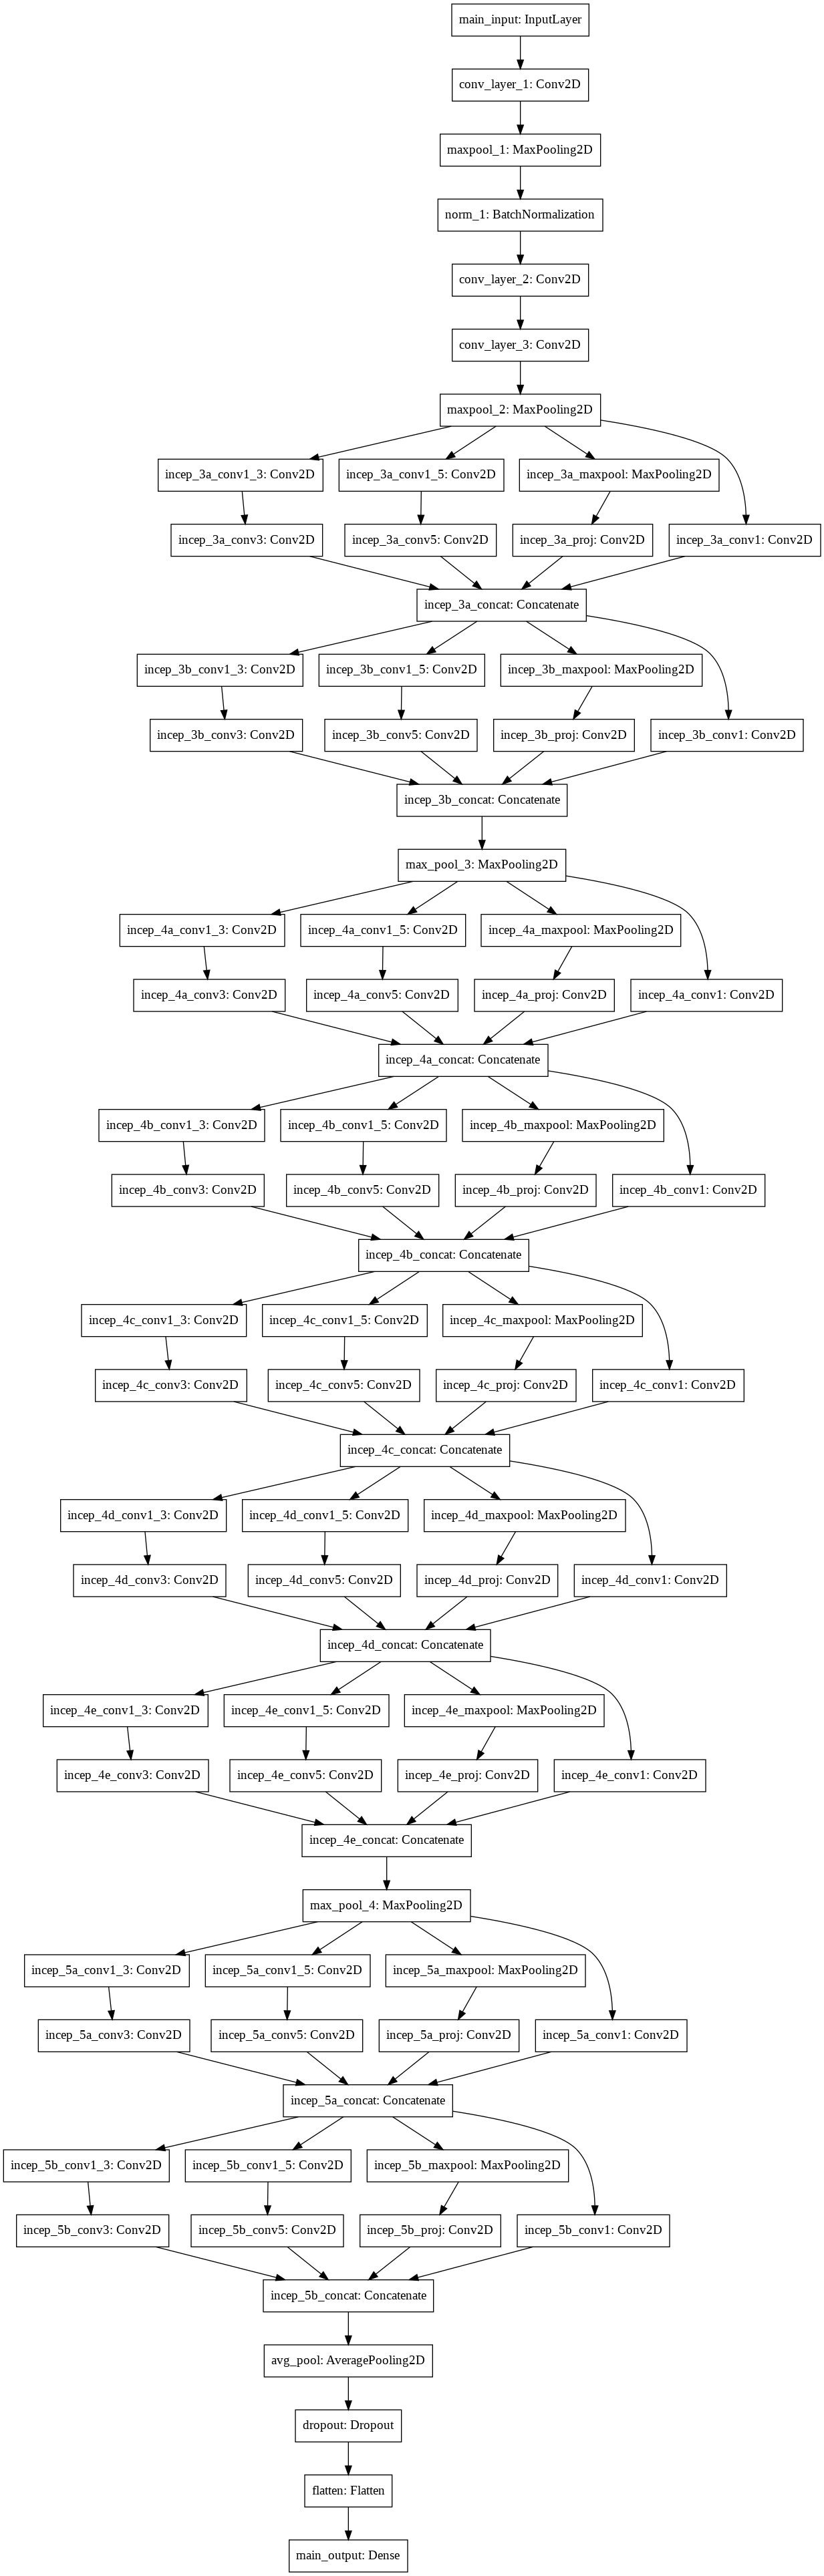

In [29]:
tf.keras.utils.plot_model(model)

# Define Callbacks & Optimizer

## Learning Rate Modification

In [30]:
def lr_schedule(epoch, learning_rate):
  #The paper talks about reducing the learning rate by 4% every 8 epochs

  #Checking if 8 epochs are complete
  if epoch > 7 and epoch%8 == 0 :
    # Reducing the learning rate by 4% 
    #print("lr_schedule: epoch =",epoch)
    return learning_rate* 0.96
  else:
    return learning_rate

lrScheduler = tf.keras.callbacks.LearningRateScheduler(schedule=lr_schedule, verbose=1)

## Checkpoint Definition

In [31]:
checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath = checkpoint_filePath
                                                , monitor='val_loss'
                                                , verbose = 1
                                                , save_best_only = True
                                                , save_weights_only = False
                                                )


## EarlyStopping Definition

In [32]:
earlyStopper = tf.keras.callbacks.EarlyStopping(monitor='val_loss'
                                                , min_delta = 0.0001
                                                , patience = 9
                                                , verbose=1
                                                , restore_best_weights=True
                                                )

## Define Callbacks list

In [33]:
callbacks = [earlyStopper
             , checkpoint
             , lrScheduler]

## Define Optimizer

In [34]:
# The paper calls for an SGD with momentum of 0.9
optimizer = tf.keras.optimizers.SGD(learning_rate=1e-3, momentum=0.9)

#optimizer = tf.keras.optimizers.Adam(learning_rate=1e-5)

# Compile the Model

In [35]:
#First phase of training will be with aux1 branch as output and ignoring the rest of the model

#aux1_model = Model(inputs=model.get_layer('main_input').input, outputs=model.get_layer('aux1_output').output)
#aux1_model.summary()

In [36]:
#aux1_model.reset_states()

In [37]:
model.compile(optimizer = optimizer 
              , loss = 'categorical_crossentropy'
              , metrics = [ 'accuracy']
              )

# Train the Model

In [38]:
metrics = model.fit(training_datasource
          , batch_size = batch_size
          , epochs= 50
          , callbacks = callbacks
          , validation_data = validation_datasource
          , shuffle=True
          )

Epoch 1/50

Epoch 00001: LearningRateScheduler reducing learning rate to 0.0010000000474974513.
54/54 [==============================] - 59s 1s/step - loss: 1.5524 - accuracy: 0.2978 - val_loss: 1.7891 - val_accuracy: 0.2367

Epoch 00001: val_loss improved from inf to 1.78906, saving model to /content/drive/MyDrive/MachineLearning/GoogleNet_experiment_1.h5
Epoch 2/50

Epoch 00002: LearningRateScheduler reducing learning rate to 0.0010000000474974513.
54/54 [==============================] - 56s 1s/step - loss: 1.2865 - accuracy: 0.4633 - val_loss: 2.0464 - val_accuracy: 0.2450

Epoch 00002: val_loss did not improve from 1.78906
Epoch 3/50

Epoch 00003: LearningRateScheduler reducing learning rate to 0.0010000000474974513.
54/54 [==============================] - 56s 1s/step - loss: 1.1377 - accuracy: 0.5387 - val_loss: 1.8578 - val_accuracy: 0.2950

Epoch 00003: val_loss did not improve from 1.78906
Epoch 4/50

Epoch 00004: LearningRateScheduler reducing learning rate to 0.001000000047

In [23]:
#tf.keras.models.save_model(model, checkpoint_filePath, save_format='h5')

## Loss and Accuracy Plots

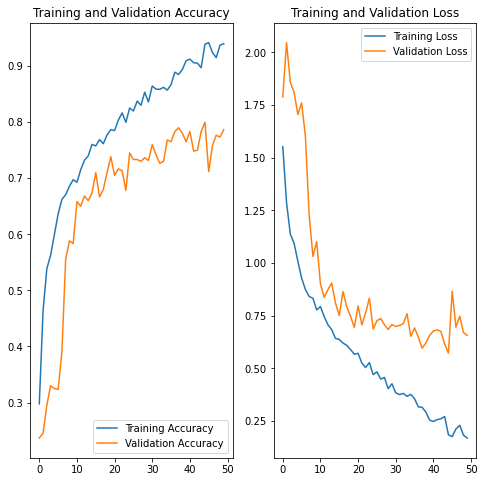

In [41]:

acc = metrics.history['accuracy']
val_acc = metrics.history['val_accuracy']

loss = metrics.history['loss']
val_loss = metrics.history['val_loss']

epochs_range = range(len(metrics.history['accuracy']))

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

# Test the Model

In [43]:
predictions = []
actuals=[]

for i, (images, labels) in enumerate( test_datasource):
  pred = model(images)
  for j in range(len(labels)):
    actuals.append( labels[j])
    predictions.append(pred[j])

# Printing a few labels and predictions to ensure that there are no dead-Relus
for j in range(10):
  print(labels[j].numpy(), "\t", pred[j].numpy())

[0. 0. 0. 1. 0.] 	 [5.2678269e-01 4.5223912e-04 1.5960732e-01 3.1243265e-01 7.2512066e-04]
[1. 0. 0. 0. 0.] 	 [9.3688345e-01 3.9315761e-05 4.2963952e-02 2.0080591e-02 3.2674830e-05]
[1. 0. 0. 0. 0.] 	 [5.6217247e-01 3.2935925e-05 6.1456640e-03 4.3134734e-01 3.0162817e-04]
[0. 1. 0. 0. 0.] 	 [2.6929042e-08 9.9104989e-01 8.4609836e-03 1.1975218e-05 4.7719607e-04]
[0. 0. 0. 1. 0.] 	 [1.1177908e-04 2.9847620e-09 7.3413408e-05 9.9979931e-01 1.5532069e-05]
[1. 0. 0. 0. 0.] 	 [6.4884788e-01 1.4298371e-07 3.5084713e-01 3.0439568e-04 4.9051403e-07]
[1. 0. 0. 0. 0.] 	 [9.9992180e-01 4.6575969e-06 3.7354968e-07 7.2269759e-05 9.6628423e-07]
[0. 0. 0. 1. 0.] 	 [2.2897586e-01 2.6874379e-03 5.8660603e-01 1.8155751e-01 1.7324543e-04]
[0. 0. 0. 1. 0.] 	 [0.4059488  0.00825622 0.0023726  0.5712473  0.01217511]
[0. 0. 0. 1. 0.] 	 [0.2535905  0.12598905 0.01019515 0.60805327 0.002172  ]


Confusion Matrix

In [45]:
import pandas as pd
pd.DataFrame(tf.math.confusion_matrix(
    np.argmax(actuals, axis=1), np.argmax(predictions, axis=1), num_classes=num_classes, dtype=tf.dtypes.int32).numpy()
    , columns = test_image_dataset.class_names
    , index =  test_image_dataset.class_names)

,dog,berry,other,bird,flower
dog,378,2,12,6,2
berry,20,339,10,3,28
other,26,11,320,17,26
bird,107,21,53,192,27
flower,5,15,17,3,360
